In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd E:/LaDECO-20220329T224131Z-001/LaDECO

/content/drive/MyDrive/ML-LaDECO/MLaDECO


In [28]:
import numpy as np

print('Project MLaDECO')
print('Author: Viswambhar Yasa')
print('Software version: 0.1')
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import models
from thermograms.Utilities import Utilities
from ml_training.dataset_generation.fourier_transformation import fourier_transformation
from ml_training.dataset_generation.principal_componant_analysis import principal_componant_analysis,segmentation_mask
from utilites.segmentation_colormap_anno import segmentation_colormap_anno
from utilites.tolerance_maks_gen import tolerance_predicted_mask
import matplotlib.pyplot as plt

Project MLaDECO
Author: Viswambhar Yasa
Software version: 0.1


In [7]:
root_path = r'utilites/datasets'
data_file_name = r'Variantenvergleich_data_irbis.hdf5'
thermal_class = Utilities()
thermal_data,experiment_list=thermal_class.open_file(root_path, data_file_name,True)
experiment_name=r'2021-05-25 - Variantenvergleich - VarioTherm Halogenlampe - Belichtungszeit 10s'
experimental_data=thermal_data[experiment_name] 

Experiments in the file 

1  :  2021-05-11 - Variantenvergleich - VarioTherm Halogenlampe - Winkel 0°
2  :  2021-05-11 - Variantenvergleich - VarioTherm Halogenlampe - Winkel 30°
3  :  2021-05-11 - Variantenvergleich - VarioTherm Halogenlampe - Winkel 45°
4  :  2021-05-11 - Variantenvergleich - VarioTherm IR-Strahler - Winkel 0°
5  :  2021-05-11 - Variantenvergleich - VarioTherm IR-Strahler - Winkel 30°
6  :  2021-05-11 - Variantenvergleich - VarioTherm IR-Strahler - Winkel 45°
7  :  2021-05-25 - Variantenvergleich - VarioTherm Halogenlampe - Belichtungszeit 10s
8  :  2021-05-25 - Variantenvergleich - VarioTherm Halogenlampe - Belichtungszeit 2s
9  :  2021-05-25 - Variantenvergleich - VarioTherm Halogenlampe - Belichtungszeit 5s


A total of 9 experiments are loaded in file  



In [8]:
experimental_data

<HDF5 dataset "2021-05-25 - Variantenvergleich - VarioTherm Halogenlampe - Belichtungszeit 10s": shape (255, 256, 1000), type "<f2">

In [9]:
from PIL import Image

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split
exp_data=np.array(experimental_data)
standardizing = StandardScaler()
std_output_data = standardizing.fit_transform(
                exp_data.reshape(exp_data.shape[0], -1)).reshape(exp_data.shape)

In [13]:
normalizing = MinMaxScaler(feature_range=(0, 1))
nrm_output_data = normalizing.fit_transform(
                exp_data.reshape(exp_data.shape[0], -1)).reshape(exp_data.shape)

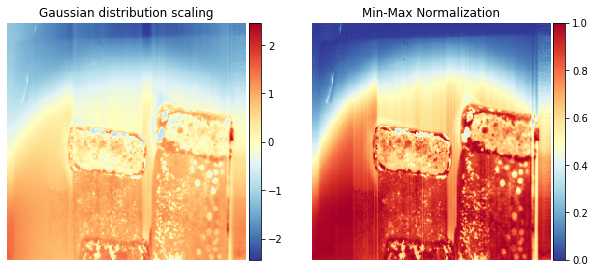

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(std_output_data[:,:,400].astype(np.float32), cmap='RdYlBu_r', interpolation='None')
ax1.set_title('Gaussian distribution scaling')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.axis('off')
ax2 = fig.add_subplot(122)
im2 = ax2.imshow(nrm_output_data[:,:,400].astype(np.float32), cmap='RdYlBu_r', interpolation='None')
ax2.set_title('Min-Max Normalization')
ax2.axis('off')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')
plt.savefig(r"Documents/temp/con_scaling.png",dpi=600,bbox_inches='tight',transparent=True)


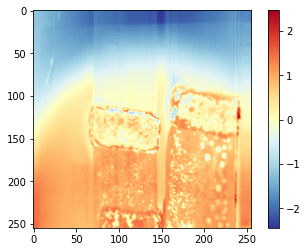

In [15]:
plt.imshow(std_output_data[:,:,400].astype(np.float32),cmap='RdYlBu_r') 
plt.colorbar()

In [16]:
experimental_data=np.array(thermal_data[experiment_name])

In [17]:
import tensorflow as tf

In [18]:
def grayscale_image(data):
  """
  Creates a gray scale image dataset from the input data 

  Args:
      data (numpy array): Thermograms

  Returns:
      (numpy array): Gray scale images
  """
  #print(data.shape)
  seq_data=np.zeros((data.shape))
  for i in range(data.shape[-1]):
    temp=np.expand_dims(data[:,:,i],axis=-1)
    #print(temp.shape)
    a_i=tf.keras.utils.array_to_img(temp).convert('L')
    #a_i=array_to_img(temp).convert('L')
    imgGray = tf.keras.utils.img_to_array(a_i)
    #print(imgGray.shape)
    seq_data[:,:,i]=np.squeeze(imgGray)
  return seq_data
d=grayscale_image(experimental_data)

In [19]:
d.shape

(255, 256, 1000)

(-0.5, 255.5, 254.5, -0.5)

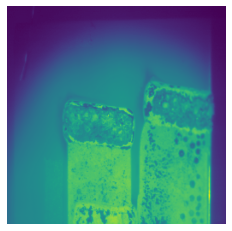

In [21]:
from PIL import Image
from keras.preprocessing.image import array_to_img,img_to_array
data=experimental_data
plt.figure()
plt.imshow(d[:,:,250])
#plt.imshow(std_output_data[:,:,250].astype(np.float64),cmap='gray')
plt.savefig("Documents/temp/con_output.png")
plt.axis('off')

In [22]:
img=plt.imread('Documents/temp/con_output.png')

In [23]:
img.shape

(288, 432, 4)

In [26]:
EOFs=principal_componant_analysis(experimental_data)

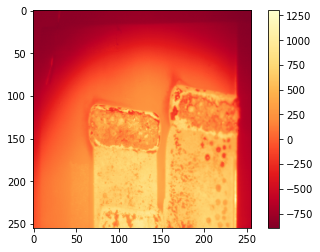

In [27]:
img1 = Image.fromarray(EOFs[:,:,0].astype(np.int8))
#img2 = Image.fromarray(EOFs[:,:,0].astype(np.float32))
plt.imshow(np.squeeze(EOFs),cmap='YlOrRd_r')
plt.colorbar()
plt.savefig("Documents/temp/con_PCA.png",dpi=600,bbox_inches='tight',transparent=True)

In [ ]:
import json
from skimage.draw import polygon
def segmentation_mask(annotaion_path,experiment_name,height=256,width=256,linesToSkip=1):
        file_name = experiment_name+'.json'
        file_path=os.path.join(annotaion_path,file_name)
        with open(file_path,'r') as file:
            annotation=json.load(file)
            #print(annotation)
            #json_key = experiment_name[:-1]+'Â'+experiment_name[-1:]
        experimental_data = annotation[experiment_name]
        region_data = experimental_data['regions']
        objects=list(region_data.keys())
        object_0=region_data['0']
        annotates = sorted(list(object_0['region_attributes']))
        #print(annotates)
        no_of_classes=len(annotates)
        masks = np.zeros((height, width, no_of_classes))
        for i in range(len(objects)):
            object_mask_data = region_data[str(i)]
            classes = object_mask_data['region_attributes']
            for (key, value) in classes.items():
                if classes[key]=='1':
                    annotate_no=annotates.index(key)
                    #print(annotate_no)
                    break
            object_shape = object_mask_data['shape_attributes']
            if object_shape['name']=='rect':
                xmin = int(object_shape['x'])
                xmax = xmin+int(object_shape['width'])
                ymin = int(object_shape['y'])
                ymax = ymin+int(object_shape['height'])
                masks[xmin:xmax, ymin:ymax, annotate_no] = 255
            elif object_shape['name'] == 'polygon':
                x_points = object_shape['all_points_x']
                y_points = object_shape['all_points_y']
                x, y = polygon(x_points, y_points, shape=(height, width))
                masks[x, y, annotate_no] = 255
            else:
                print('Object shape no found', object_shape['name'] )
        #print(masks.shape)
        output_masks = masks.transpose(1, 0, 2)
        #print(output_masks.shape)
        combined_mask = np.zeros((height, width))
        for i in range(no_of_classes):
            #print(i)
            temp = output_masks[:, :, i]
            temp[temp == 255]=i+1
            combined_mask += temp
        return output_masks,combined_mask

In [30]:
annotation_path=r'ml_training/dataset_generation/masks/JSON'
output_masks,combined_mask=segmentation_mask(annotation_path,experiment_name)

In [31]:
combined_mask.shape

(256, 256)

In [32]:
temp_mask=combined_mask

In [33]:
thermal_band=np.where(temp_mask==3)

In [34]:
temp_mask[temp_mask==1]=1
temp_mask[temp_mask==2]=1
temp_mask[temp_mask==3]=2
temp_mask[temp_mask==0]=0

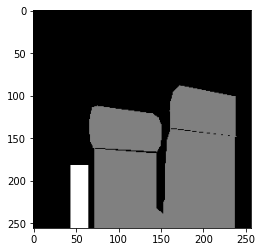

In [36]:
plt.imshow(temp_mask,cmap='binary_r',)
plt.imsave('Documents/temp/con_manual_mask.png',temp_mask[:255,:255],cmap='binary_r')

In [37]:
mask=np.zeros(shape=(np.squeeze(EOFs).shape))
mask[np.squeeze(EOFs) > 220]=1
#mask[np.where((np.squeeze(EOFs) >= -150) & (np.squeeze(EOFs) <=-10))]=2
#mask[np.squeeze(EOFs) <= -300]=4
#mask[np.where((np.squeeze(EOFs) >= -300) & (np.squeeze(EOFs) <=0))]=3
plt.imsave('Documents/temp/con_mask1.png',np.squeeze(mask[:255,:255]),cmap='binary_r')

In [38]:
substrate=mask

In [39]:
temp_mask[temp_mask==2]=0

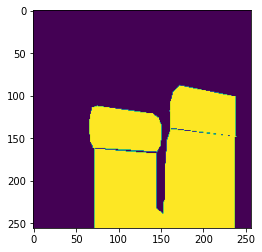

In [40]:
plt.imshow(temp_mask)

In [41]:
import cv2

img1 = cv2.imread('Documents/temp/con_manual_mask.png',0)
img21 = cv2.imread('Documents/temp/con_mask1.png',0)
print(img1.shape,img21.shape)

(255, 255) (255, 255)


In [42]:
img1.shape,np.unique(img1)

((255, 255), array([  0, 128, 255], dtype=uint8))

In [43]:
img1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

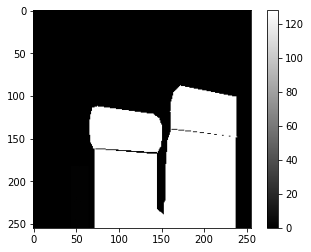

In [44]:
img1[img1==255]=1
plt.imshow(img1,cmap='binary_r')
plt.colorbar()

In [45]:
np.unique(img21)

array([  0, 255], dtype=uint8)

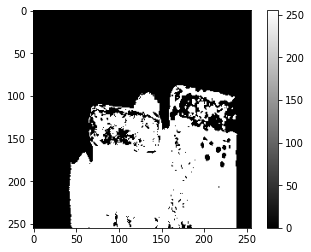

In [46]:
#img2[img2==255]=1
plt.imshow(img21,cmap='binary_r')
plt.colorbar()

In [47]:
img_bwa = cv2.bitwise_and(img1,img21)
img_bwo = cv2.bitwise_or(img1,img21)
img_bno = cv2.bitwise_not(img1,img21)
img_bwx = cv2.bitwise_xor(img_bwa,img21)

In [48]:
np.unique(img_bwx)

array([127, 254, 255], dtype=uint8)

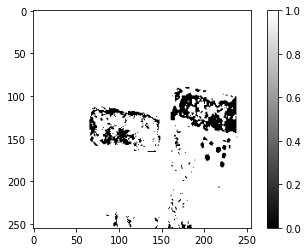

In [49]:
img_bwx[img_bwx==255]=1
img_bwx[img_bwx==254]=1
img_bwx[img_bwx==127]=0
plt.imshow(img_bwx,cmap='binary_r')
plt.colorbar()

In [50]:
np.unique(img_bwa)

array([  0,   1, 128], dtype=uint8)

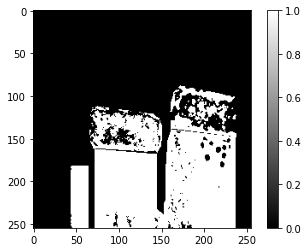

In [51]:
img_bwa[img_bwa==128]=1
plt.imshow(img_bwa,cmap='binary_r')
plt.colorbar()

In [52]:
import matplotlib.pyplot as plt

In [54]:
categorical_mask=np.zeros((255,255,3))
categorical_mask[:,:,0]=img21
categorical_mask[:,:,1]=img_bwa
categorical_mask[:,:,2]=img_bwx
print(np.unique(categorical_mask),np.unique(img_bno))
combined_mask=np.zeros((255,255))
for i in range(0,3):
  print(i)
  
  temp = categorical_mask[:, :, i]
  temp[temp == 1]=i
  combined_mask += temp

[  0.   1. 127. 254. 255.] [127 254 255]
0
1
2


In [55]:
combined_mask[combined_mask==3]=1
combined_mask[combined_mask==0]=3
combined_mask[combined_mask==2]=0
combined_mask[combined_mask==3]=2
#combined_mask[combined_mask==2]=0
#combined_mask[combined_mask==3]=0

In [56]:
combined_mask[thermal_band]=3

IndexError: ignored

In [57]:
name='/content/'+experiment_name

In [58]:
np.save(name,combined_mask)

In [59]:
ar=np.load(name+'.npy')

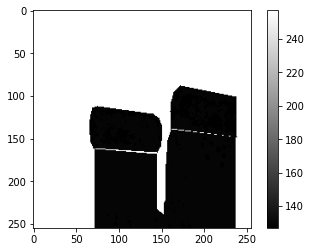

In [60]:
plt.imshow(ar,cmap='gray')
plt.colorbar()

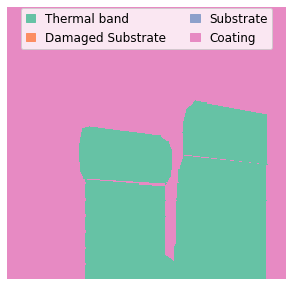

In [61]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd
fig, ax = plt.subplots(figsize=(5, 5))
cmap = sns.mpl_palette("Set2", 4)
c=sns.heatmap(data=ar, cmap=cmap, cbar=False)
plt.axis('off')

legend_handles = [Patch(color=cmap[0], label='Thermal band '),  # red
                  Patch(color=cmap[1], label='Damaged Substrate'),
                  Patch(color=cmap[2], label='Substrate'),
                  Patch(color=cmap[3], label='Coating')]  # green
plt.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.5, 1.02], loc='upper center', fontsize=12, handlelength=.8)
fig = c.get_figure()
fig.savefig("/content/final_mask.png",dpi=600,bbox_inches='tight',transparent=True) 